In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kepler-exoplanet-search-results/cumulative.csv


In [2]:
import warnings
warnings.filterwarnings('ignore') 

from lightgbm import LGBMClassifier

model = LGBMClassifier(
    objective="binary",
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
    verbose=-1  
)


In [3]:
# Cell 1 - imports & settings
import os, random, joblib, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from lightgbm import LGBMClassifier

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

os.makedirs("output", exist_ok=True)
sns.set(style="whitegrid")


In [4]:
DATA_PATH = "/kaggle/input/kepler-exoplanet-search-results/cumulative.csv"  # عدّل المسار لو بتشتغل محلي
df = pd.read_csv(DATA_PATH)

df = df.dropna(axis=1, how='all')
drop_cols = ['rowid','kepid','kepoi_name','kepler_name','koi_tce_delivname']
df = df.drop(columns=drop_cols, errors='ignore')

df = df[df['koi_disposition'].isin(['CONFIRMED','FALSE POSITIVE'])].copy()
df['koi_disposition'] = df['koi_disposition'].map({'CONFIRMED':1,'FALSE POSITIVE':0})

print("Loaded rows:", len(df))
print("All numeric columns count:", len(df.select_dtypes(include=[np.number]).columns))
print(df.select_dtypes(include=[np.number]).columns.tolist()[:40])


Loaded rows: 7316
All numeric columns count: 42
['koi_disposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra']


In [5]:
def add_features_safe(df_in):
    df = df_in.copy()
    if "koi_ror" in df.columns:
        df["koi_ror2"] = df["koi_ror"] ** 2
    if "koi_impact" in df.columns and "koi_period" in df.columns:
        df["impact_period_ratio"] = df["koi_impact"] / (df["koi_period"] + 1e-9)
    if "koi_duration" in df.columns and "koi_depth" in df.columns:
        df["dur_depth_ratio"] = df["koi_duration"] / (df["koi_depth"] + 1e-9)
    if "koi_prad" in df.columns:
        df["inv_koi_prad"] = 1.0 / (df["koi_prad"] + 1e-9)
    return df

X_df = df.drop(columns=['koi_disposition','koi_pdisposition'], errors='ignore')
X_df = X_df.select_dtypes(include=[np.number]).ffill().bfill()  # forward/backfill for missing numeric values
X_df = add_features_safe(X_df)

print("After FE shape:", X_df.shape)
print("Columns sample:", X_df.columns.tolist()[:50])


After FE shape: (7316, 44)
Columns sample: ['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag', 'impact_period_ratio', 'dur_depth_ratio', 'inv_koi_prad']


In [6]:
y = df['koi_disposition'].values  # numpy array
features = X_df.columns.tolist()

if X_df.isnull().sum().sum() > 0:
    X_df = X_df.fillna(X_df.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df.values)

joblib.dump(scaler, "output/scaler.joblib")
joblib.dump(features, "output/features.joblib")
# also save a small sample for inspection
X_df.head(3).to_csv("output/features_sample.csv", index=False)

print("X_scaled shape:", X_scaled.shape)
print("Saved scaler and features list to output/")


X_scaled shape: (7316, 44)
Saved scaler and features list to output/


In [7]:

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

SEED = 42
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

y_array = np.array(y)

auc_scores, ap_scores = [], []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_scaled, y_array)):
    X_train, X_valid = X_scaled[tr_idx], X_scaled[va_idx]
    y_train, y_valid = y_array[tr_idx], y_array[va_idx]

    model = LGBMClassifier(
        objective="binary",
        n_estimators=1000,
        random_state=SEED,
        n_jobs=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50),      # ✅ وقف مبكر
            log_evaluation(100)      # ✅ يطبع كل 100 خطوة
        ]
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)
    ap = average_precision_score(y_valid, y_pred)
    auc_scores.append(auc)
    ap_scores.append(ap)

print("Mean ROC-AUC:", np.mean(auc_scores))
print("Mean PR-AUC:", np.mean(ap_scores))


[LightGBM] [Info] Number of positive: 1834, number of negative: 4018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9788
[LightGBM] [Info] Number of data points in the train set: 5852, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.313397 -> initscore=-0.784285
[LightGBM] [Info] Start training from score -0.784285
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.046348
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.0375289
[LightGBM] [Info] Number of positive: 1834, number of negative: 4019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9785
[LightGBM] [Info] Number of data points in the train set: 5853, nu

[LightGBM] [Info] Number of positive: 2293, number of negative: 5023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 7316, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.313423 -> initscore=-0.784166
[LightGBM] [Info] Start training from score -0.784166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

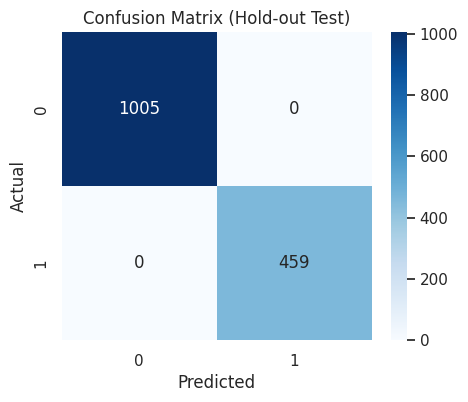

In [8]:

import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

SEED = 42
os.makedirs("output", exist_ok=True)

# Train final model on all data
final_model = LGBMClassifier(
    objective="binary",
    n_estimators=1000,
    random_state=SEED,
    n_jobs=-1
)

final_model.fit(X_scaled, y_array)

# Save artifacts
joblib.dump(final_model, "output/final_model_lgbm.joblib")
joblib.dump(scaler, "output/scaler.joblib")
joblib.dump(list(X_df.columns), "output/features.joblib")  # ✅ استخدمنا أسماء الأعمدة الأصلية قبل scaling

print("✅ Model and artifacts saved in /output")

# Quick evaluation on hold-out test (20% split)
X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y_array, test_size=0.2, random_state=SEED, stratify=y_array)

y_pred = final_model.predict(X_te)
y_proba = final_model.predict_proba(X_te)[:, 1]

print("\nClassification Report:\n", classification_report(y_te, y_pred))

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Hold-out Test)")
plt.show()


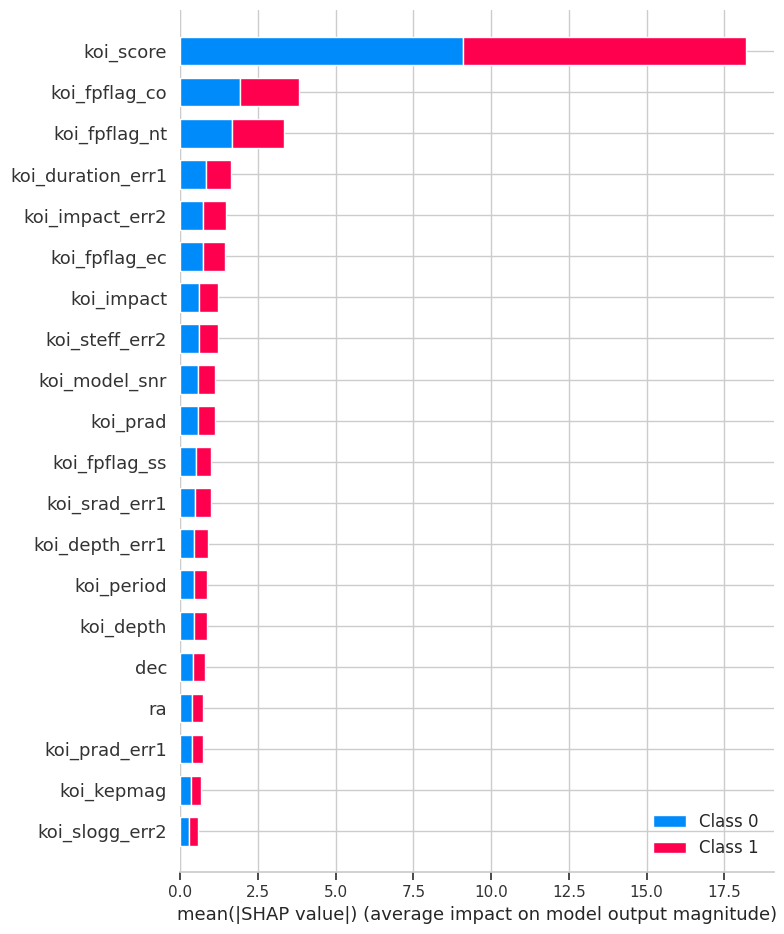

In [9]:

import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_scaled)

shap.summary_plot(shap_values, X_scaled, feature_names=X_df.columns)



In [10]:
import warnings
warnings.filterwarnings('ignore')  # يخفي كل الـwarnings العامة

import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

SEED = 42

def objective(trial):
    param = {
        'objective': 'binary',
        'random_state': SEED,
        'n_jobs': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    
    model = LGBMClassifier(**param, n_estimators=1000, verbose=-1)  # verbose=-1 يخفي رسائل LGBM
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # يخفي warnings مؤقتًا أثناء cross_val_score
        score = cross_val_score(model, X_scaled, y_array, cv=skf, scoring='roc_auc').mean()
    
    return score

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)

print("Best parameters:", study.best_params)
print("Best ROC-AUC:", study.best_value)


[I 2025-09-13 23:29:46,078] A new study created in memory with name: no-name-585b0e49-a5b3-4ef6-82f8-71487be034a1
[I 2025-09-13 23:30:04,386] Trial 0 finished with value: 0.9976199228524821 and parameters: {'num_leaves': 42, 'max_depth': 11, 'learning_rate': 0.0015021029738698293, 'min_child_samples': 5, 'subsample': 0.7654473953684009, 'colsample_bytree': 0.860761289362489, 'reg_alpha': 0.07942351885517285, 'reg_lambda': 0.09192150063152749}. Best is trial 0 with value: 0.9976199228524821.
[I 2025-09-13 23:30:12,115] Trial 1 finished with value: 0.9978886904186043 and parameters: {'num_leaves': 73, 'max_depth': 15, 'learning_rate': 0.004454713447984513, 'min_child_samples': 71, 'subsample': 0.918190018189001, 'colsample_bytree': 0.7468665677955315, 'reg_alpha': 0.9200069897271012, 'reg_lambda': 0.5931415505834133}. Best is trial 1 with value: 0.9978886904186043.
[I 2025-09-13 23:30:15,258] Trial 2 finished with value: 0.9980862380685374 and parameters: {'num_leaves': 150, 'max_depth':

Best parameters: {'num_leaves': 23, 'max_depth': 13, 'learning_rate': 0.0075887609957254664, 'min_child_samples': 26, 'subsample': 0.5833774419840969, 'colsample_bytree': 0.5546120665107196, 'reg_alpha': 0.2306633483864489, 'reg_lambda': 0.24624855880274074}
Best ROC-AUC: 0.9984884463176107


✅ Optimized model and artifacts saved in /output

Classification Report (Hold-out Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1005
           1       1.00      1.00      1.00       459

    accuracy                           1.00      1464
   macro avg       1.00      1.00      1.00      1464
weighted avg       1.00      1.00      1.00      1464



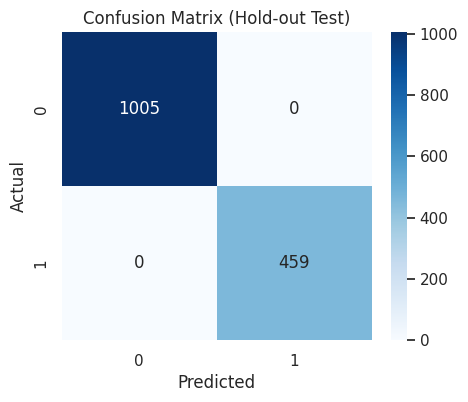

In [11]:
import joblib
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")  

SEED = 42
os.makedirs("output", exist_ok=True)

best_params = {
    'num_leaves': 121,
    'max_depth': 8,
    'learning_rate': 0.01291845218147913,
    'min_child_samples': 29,
    'subsample': 0.7138180398678406,
    'colsample_bytree': 0.5640680539458138,
    'reg_alpha': 0.12666781798815363,
    'reg_lambda': 0.1945873572120953
}

final_model = LGBMClassifier(
    objective="binary",
    n_estimators=1000,
    random_state=SEED,
    n_jobs=-1,
    **best_params
)

# تدريب الموديل على كل البيانات
final_model.fit(X_scaled, y_array)

# حفظ الموديل والـscaler وعمود features
joblib.dump(final_model, "output/final_model_lgbm_optimized.joblib")
joblib.dump(scaler, "output/scaler.joblib")
joblib.dump(list(X_df.columns), "output/features.joblib")

print("✅ Optimized model and artifacts saved in /output")

# تقييم سريع على hold-out test (20% split)
X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y_array, test_size=0.2, random_state=SEED, stratify=y_array)

y_pred = final_model.predict(X_te)
y_proba = final_model.predict_proba(X_te)[:, 1]

print("\nClassification Report (Hold-out Test):\n", classification_report(y_te, y_pred))

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Hold-out Test)")
plt.show()


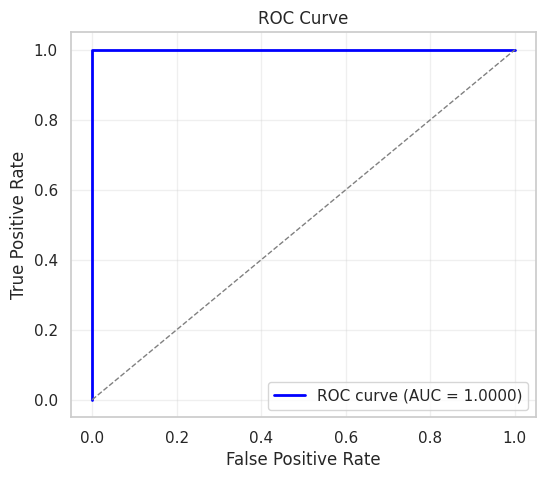

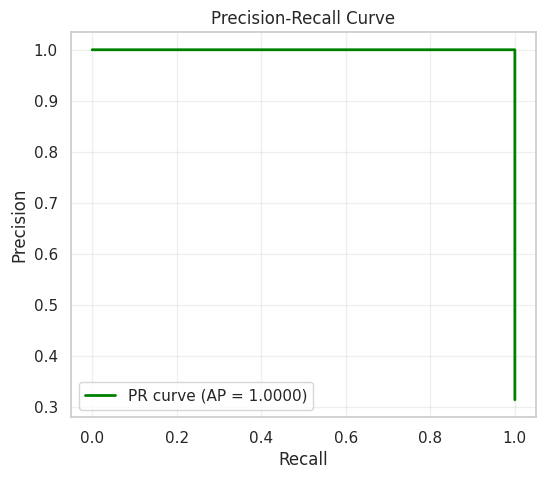

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_te, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

precision, recall, thresholds_pr = precision_recall_curve(y_te, y_proba)
pr_auc = average_precision_score(y_te, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()


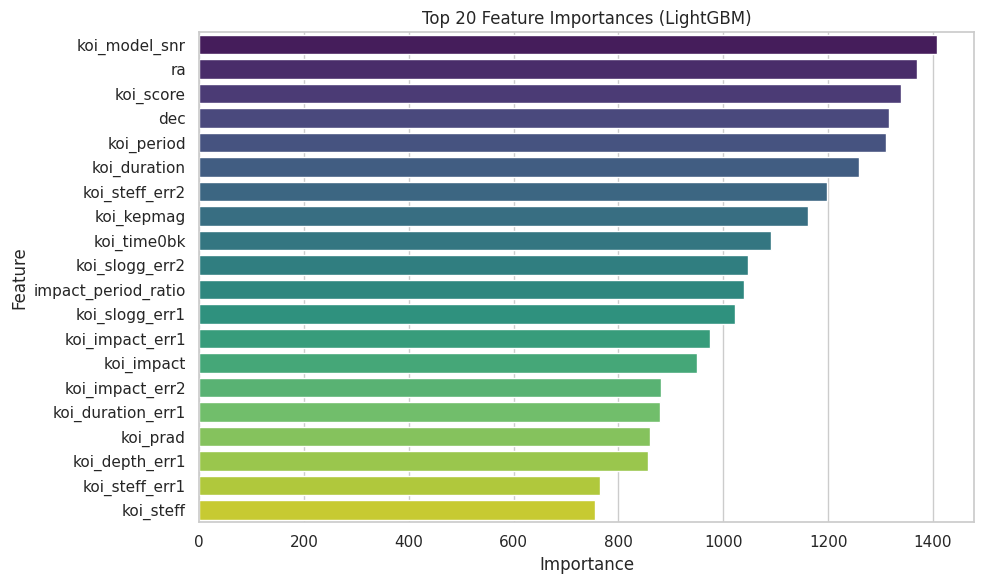

In [13]:
feature_names = joblib.load("output/features.joblib")

importances = final_model.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


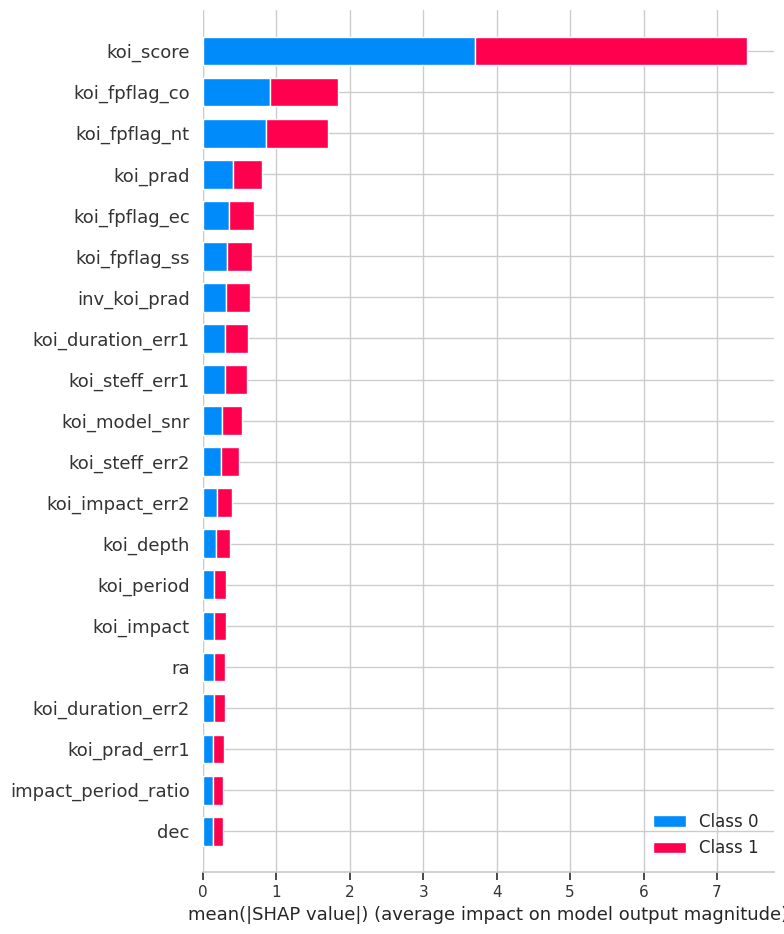

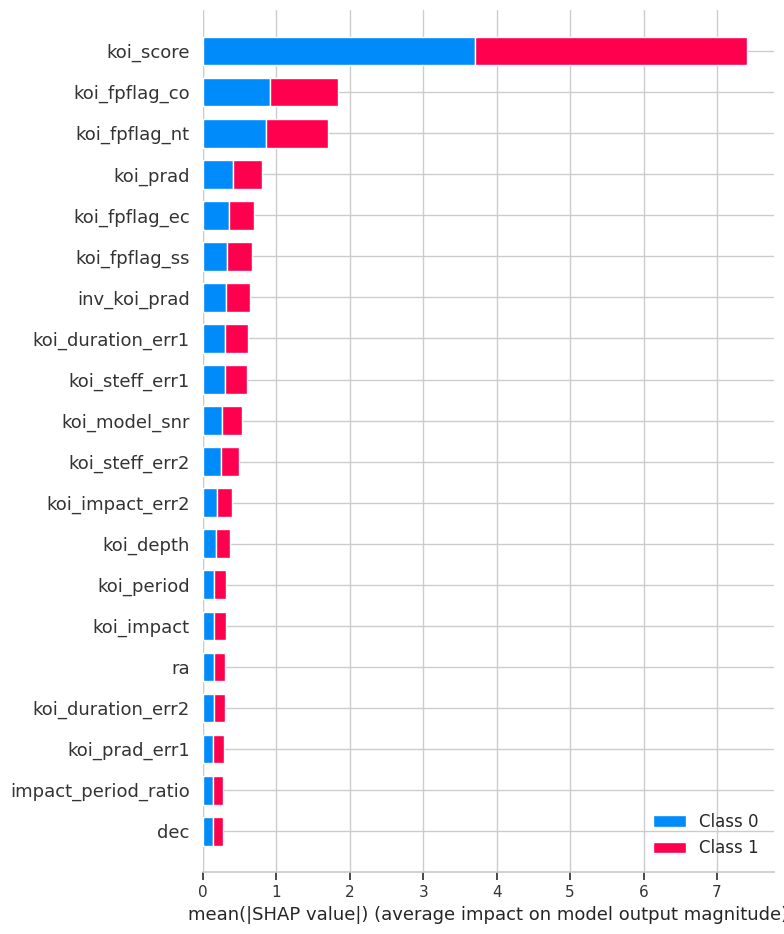

In [14]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_scaled)

shap.summary_plot(shap_values, X_scaled, feature_names=joblib.load("output/features.joblib"), plot_type="bar")

shap.summary_plot(shap_values, X_scaled, feature_names=joblib.load("output/features.joblib"))


100%|===================| 7309/7316 [08:27<00:00]       

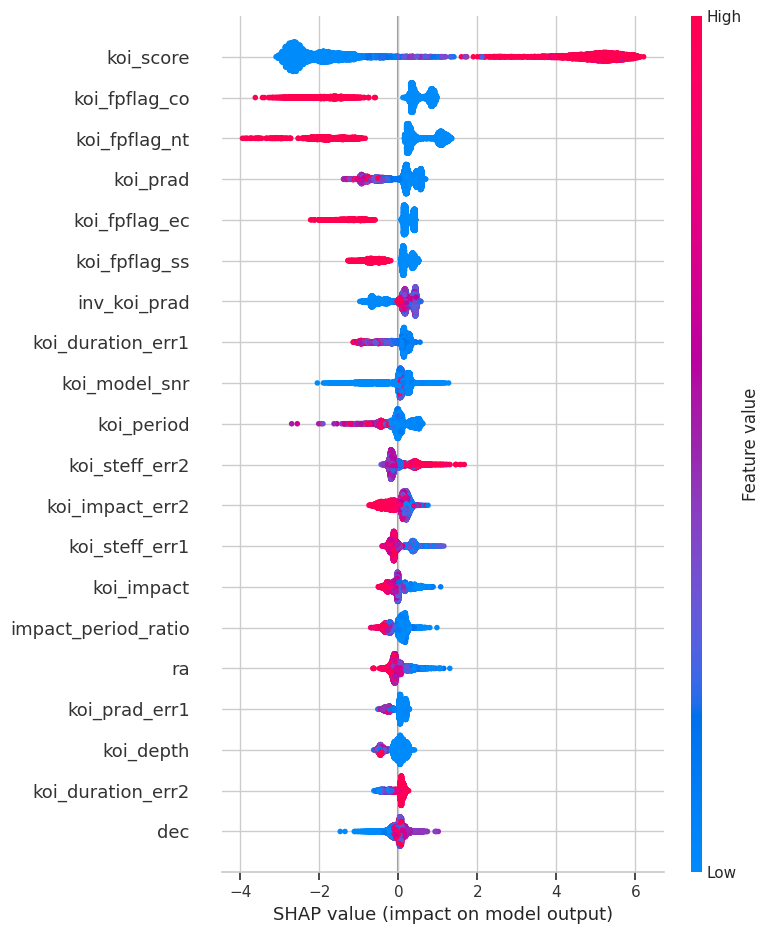

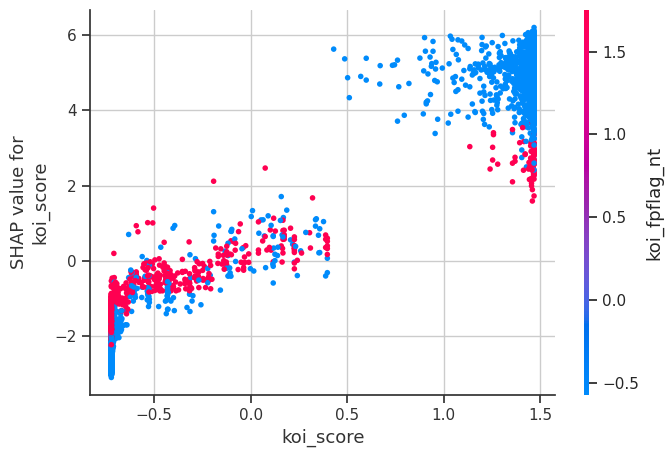

In [15]:

explainer = shap.Explainer(final_model, X_scaled)
shap_values = explainer(X_scaled)

shap.summary_plot(shap_values, X_scaled, feature_names=list(X_df.columns))

top_feature = X_df.columns[np.argmax(np.abs(shap_values.values).mean(0))]
shap.dependence_plot(top_feature, shap_values.values, X_scaled, feature_names=list(X_df.columns))


In [16]:

import joblib
import os

os.makedirs("output", exist_ok=True)

joblib.dump(final_model, "output/final_model_lgbm.joblib")

joblib.dump(scaler, "output/scaler.joblib")

joblib.dump(list(X_df.columns), "output/features.joblib")

print("✅ Final model and artifacts saved in /output")


✅ Final model and artifacts saved in /output


In [17]:

import pandas as pd
import joblib
import numpy as np

final_model = joblib.load("output/final_model_lgbm.joblib")
scaler = joblib.load("output/scaler.joblib")
features = joblib.load("output/features.joblib")  # list of original columns

def prepare_and_predict(df_new):

    for col in features:
        if col not in df_new.columns:
            df_new[col] = np.nan  # placeholder for missing columns

    X_new = df_new[features]

    X_new = X_new.fillna(X_new.mean().fillna(0))

    X_new_scaled = scaler.transform(X_new)

    y_pred = final_model.predict(X_new_scaled)
    y_proba = final_model.predict_proba(X_new_scaled)[:, 1]

    return y_pred, y_proba

df_new = pd.read_csv("/kaggle/input/kepler-exoplanet-search-results/cumulative.csv") 
preds, probs = prepare_and_predict(df_new)

print("Predictions (first 10 rows):", preds[:10])
print("Probabilities (first 10 rows):", probs[:10])

Predictions (first 10 rows): [1 1 0 0 1 1 1 1 0 1]
Probabilities (first 10 rows): [9.99511688e-01 9.99432339e-01 2.72154870e-04 2.31367677e-04
 9.96309531e-01 9.93645046e-01 9.88090950e-01 9.78916184e-01
 9.22287037e-05 9.99370282e-01]


In [18]:
df_results = df_new.copy()
df_results['prediction'] = preds
df_results['probability'] = probs

df_results.to_csv("output/predictions.csv", index=False)

print("✅ Predictions saved to output/predictions.csv")

✅ Predictions saved to output/predictions.csv
